In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from numba import njit, prange
%matplotlib widget

In [2]:
@njit
def W(r, h, dim):
    """Wendland C4 kernel, 2D."""
    q = np.abs(r)/h
    coef = 3/(4*np.pi*h**dim)
    return np.where(q <= 2, coef * (1-q/2)**6 * (35*(q/2)**2 + 18*q/2 + 3), 0.0)

@njit
def dW(r, h, dim):
    """Derivative of Wendland C4 kernel, 2D."""
    q = np.abs(r)/h
    coef = 21/(4*np.pi*h**(dim+1))
    sign = np.sign(r)
    return sign * np.where(q <= 2, coef * -q *(1-q/2)**5 * (2+5*q), 0.0)

In [3]:

def get_nearest_neighbors(points, k=8, boxsize=None):
    """
    Finds the k nearest neighbors for each point in a point set using scipy.spatial.cKDTree.

    Parameters:
    ----------
    points : ndarray of shape (N, D)
        The input array of N points in D-dimensional space.
    k : int
        The number of nearest neighbors to find

    Returns:
    -------
    neighbors_indices : ndarray of shape (N, k)
        Indices of the k nearest neighbors for each point, incl. self
    neighbors_distances : ndarray of shape (N, k)
        Distances to the k nearest neighbors for each point, incl. self
    """
    if not isinstance(points, np.ndarray):
        points = np.array(points)

    tree = KDTree(data=points, boxsize=boxsize)
    distances, indices = tree.query(x=points, k=k)

    return indices, distances

In [16]:
@njit(fastmath=True,parallel=True)
def get_hydro_interaction( X, idx, dist, m, V, u, gamma, CFLfac, Nngb, boxsize, adapt_smoothing_iteratively, rho_floor=1e-6, hmin=-1.0 ):
  """
  Compute hydrodynamic interactions for SPH particles.

  Parameters:
    X (ndarray):    Particle positions.
    idx (ndarray):  Indices of nearest neighbors for each particle.
    dist (ndarray): Distances to nearest neighbors for each particle.
    m (ndarray):    Particle masses.
    V (ndarray):    Particle velocities.
    u (ndarray):    Particle internal energies.
    gamma (float):  Adiabatic index.
    CFLfac (float): CFL safety factor.
    Nngb (int):     Number of neighbors.
    adapt_smoothing_iteratively (bool): Whether to iteratively adapt smoothing lengths.

  Returns:
    dV (ndarray):   Accelerations for each particle.
    de (ndarray):   Rate of change of internal energy for each particle.
    dt (float):     Timestep.
    rho (ndarray):  Densities for each particle.
  """
  N = X.shape[0]
  dim = X.shape[1]

  l2 = boxsize/2
  l  = boxsize
  def wrap(x, y):
      d = x - y
      # Handle both scalar and array input for periodic boundary conditions
      d = np.asarray(d)
      d = np.where(d > l2, d - l, d)
      d = np.where(d < -l2, d + l, d)
      return d
  
  def norm(v):
    return np.sqrt(np.dot(v,v))

  hi = dist[:,Nngb-1]/2  # starting guess for smoothing: distance to Nngb-th neighbour
  himin = dist[:,Nngb-4]/2    # minimum smoothing length: distance to 4th-neighbour
  himax = dist[:,-1]/2   # maximum smoothing length: as much as is provided

  if adapt_smoothing_iteratively:
    # Iteratively solve for consistent density and smoothing length
    rho = np.zeros(N,dtype=np.float64)
    rho_old = np.ones(N,dtype=np.float64) * 1e10  # Initialize with large value for convergence check
    h_factor = 1.1
    max_iterations = 6
    tolerance = 1e-3

    # Iterate until convergence
    for iteration in range(max_iterations):
        # Compute density with current smoothing lengths
        rho = np.zeros(N)
        for i in prange(N):
          for j in idx[i,:]:
            hij = 0.5*(hi[i] + hi[j])
            rij = norm( wrap( X[i,:], X[j,:] ) )
            rho[i] += m[j] * W(rij, hij, dim)
        
        # Check convergence
        if np.max(np.abs(rho - rho_old)/(rho)) < tolerance:
            break
            
        # Store current density for next iteration
        rho_old = rho.copy()
        
        # Update smoothing lengths
        for i in prange(N):
            h_new = h_factor * (m[i]/rho[i])**(1.0/dim)  # 1D: h ∝ m^(1/d)/ρ^(1/d)
            # Relaxation factor to prevent oscillations
            h_new = 0.7 * hi[i] + 0.3 * h_new
            # Minimum/maximum bound on smoothing length
            hi[i] = max(min(max(h_new,himin[i]),hi[i]),hmin)
            # hi[i] = min(max(h_new, himin[i]), himax[i]) 
  else:
    # compute density
    rho = np.zeros(N)
    for i in range(N):
        for j in idx[i,:]:
            hij = 0.5*(hi[i] + hi[j])
            rij = norm( wrap( X[i,:], X[j,:] ) )
            rho[i] += m[j] * W(rij, hij, dim)

  # Ensure density is positive
  rho = np.maximum(rho, rho_floor)  # Avoid division by zero

  # Compute pressure and sound speed
  P = (gamma - 1) * rho * u
  c = np.sqrt(gamma * P/rho)
  
  # Determine time step from Courant condition
  Vnorm = np.zeros(V.shape[0])
  for idim in range(dim):
     Vnorm += V[:,idim]**2
  Vnorm = np.sqrt(Vnorm)

  dt = CFLfac * np.min(hi /(Vnorm + c))

  # Determine velocity gradients needed for Balsara switch, compute Balsara factors
  div_v = np.zeros(N)
  curl_v = np.zeros((N,dim))
  balsara = np.zeros(N)
  for i in prange(N):
      for j in idx[i,1:Nngb]:
          hij = 0.5 * (hi[i] + hi[j])
          vij = V[i,:] - V[j,:]
          dij = wrap(X[i,:], X[j,:])
          rij = norm(dij)
              
          # Gradient of kernel
          dwij = dij/rij * dW(rij, hij, dim)
          
          # Contribution to divergence (∇·v)
          div_v[i] += m[j]/rho[j] * (vij @ dwij)
          
          # Contribution to curl magnitude (|∇×v|) - only relevant in 2D and 3D
          if dim >= 2:
              curl_term = m[j]/rho[j] * np.cross( vij, dwij ) 
              curl_v[i,:] += curl_term
      
      # Take absolute value of divergence
      div_v[i] = np.abs(div_v[i])
      
      # Take square root to get curl magnitude
      if dim >= 2:
          curl_v[i,0] = norm(curl_v[i,:])

      small_number = 0.001 * c[i]/hi[i]  # Prevent division by zero
      balsara[i] = div_v[i] / (div_v[i] + curl_v[i,0] + small_number)

  # Compute acceleration and du/dt
  dV = np.zeros((N,dim))
  de = np.zeros(N)
  for i in prange(N):
    # Compute density gradient factor (needed for correction terms)
    sum_term = 0.0
    for j in idx[i,1:Nngb]:
      hij = 0.5 * (hi[i] + hi[j])
      dij = wrap(X[i,:], X[j,:])
      rij = norm(dij)
      sum_term -= m[j] * rij * dW(rij, hij, dim) / rho[j]
    
    # Dimensionality factor (1 for 1D)
    omega = 1.0 + (hi[i]/dim) * sum_term

    for j in idx[i,1:Nngb]: # exclude self
      hij = 0.5 * (hi[i] + hi[j])
      vij = V[i,:] - V[j,:]
      dij = wrap(X[i,:], X[j,:])
      rij = norm(dij)
      wij = dij/rij * dW(rij, hij, dim)
      # wij = dij * dW(rij, hij, dim)

      # Lattanzio et al. 1985 viscosity with Balsara switch
      pi_ij = 0.0
      mu_ij = hij * (vij@dij) / (rij**2 + 0.01 * hij**2)
      if vij @ dij < 0:
          alpha = 1.0  # Viscosity parameter
          beta  = 2.0  # Second viscosity parameter
          # Apply Balsara switch as average of particle factors
          f_ij = np.minimum(np.maximum(0.5 * (balsara[i] + balsara[j]),0.1),1.0)
          pi_ij = f_ij * (-alpha * mu_ij * (c[i] + c[j])/2 + beta * mu_ij**2) / ((rho[i] + rho[j])/2)
          
      # # Monaghan & Gingold SPH 
      # dV[i] -= m[j] * (P[i]/rho[i]**2 + P[j]/rho[j]**2 + pi_ij) * wij / omega
      # de[i] += 0.5 * m[j] * (P[i]/rho[i]**2 + P[j]/rho[j]**2 + pi_ij) * (vij @ wij) / omega

      # Hernquist & Katz SPH
      # dV[i] -= m[j] * (2*np.sqrt(P[j]*P[i])/rho[j]/rho[i] + pi_ij) * wij / omega
      # de[i] += 0.5 * m[j] * (2*np.sqrt(P[j]*P[i])/rho[j]/rho[i] + pi_ij) * (vij @ wij) / omega

      # Saitoh & Makino SPH
      dV[i,:] -= m[j] * ((P[i]+P[j])/(rho[i]*rho[j]) + pi_ij) * wij  / omega
      de[i] += 0.5 * m[j] * ((P[i]+P[j])/(rho[i]*rho[j]) + pi_ij) * (vij @ wij) / omega

  return dV, de, dt, rho

In [17]:

def get_hydro_update( X, m, V, u, gamma, CFLfac = 0.9, Nngb=8, boxsize=None, adapt_smoothing_iteratively=True, hmin=-1.0 ):

  # determine distances and interaction lists
  idx, dist = get_nearest_neighbors( X, Nngb+2, boxsize )
  
  # call numba njitted interaction calculation (cannot include NN determination)
  return get_hydro_interaction( X, idx, dist, m, V, u, gamma, 
                               CFLfac, Nngb, boxsize, adapt_smoothing_iteratively, hmin=hmin )

In [18]:

# Parameters
N = 256                    # Number of particles
Lbox = 1.0
gamma = 5/3 #1.4                # Adiabatic index
dx = Lbox / N
t_end = 1.0

hmin = -1.0 #0.1*dx

Nngb = 17
CFLfac = 0.4

q = np.linspace(0, Lbox, N,endpoint=False) 
X = np.zeros((N**2,2))
X[:,0] = np.repeat(q,N)
X[:,1] = np.tile(q,N)

# rho = np.ones((N**2))
# rho[ (X[:,0]>0.25)&(X[:,1]>0.25)&(X[:,0]<0.75)&(X[:,1]<0.75) ] = 64.0

# P   = 2.5 * np.ones((N**2))
# V   = np.zeros_like(X)
# u   = P / ((gamma - 1) * rho)
# m   = rho * dx**2 

rho = np.ones((N**2))
passive = np.ones((N**2))
P   = 10.0*np.ones((N**2))
inner = (X[:,1]>0.25)&(X[:,1]<0.75)
outer = ~inner
passive[ inner ] = 2.0
rho[ inner ] = 1.0

V   = np.zeros_like(X)
V[ inner,0 ] = 1.0
V[ outer,0 ] = -1.0

X[:,1] += 0.02 * np.sin(2*np.pi*X[:,0])
X = np.mod( X+Lbox, Lbox)

u   = P / ((gamma - 1) * rho)
m   = rho * dx**2 

In [19]:

t = 0.0
istep = 0
dt = None
while t<t_end:
  dtmax = t_end-t
  if istep == 0:
    dV, de, dt, _ = get_hydro_update( X, m, V, u, gamma, CFLfac=CFLfac, Nngb=Nngb, boxsize=Lbox )
    print(f'initial time step proposed: ∆t = {dt:.4g}')

  # Kick
  V += dt/2 * dV
  u += dt/2 * de
  u = np.maximum( u, 1e-6 )

  # drift leapfrog update
  X = np.mod( Lbox + X + dt * V, Lbox )

  # Second kick update
  dV, de, dtnew, rho = get_hydro_update( X, m, V, u, gamma, CFLfac=CFLfac, Nngb=Nngb, boxsize=Lbox, hmin=hmin )
  V += dt/2 * dV
  u += dt/2 * de
  u = np.maximum( u, 1e-6 )


  P = (gamma - 1) * rho * u
  t += dt
  istep = istep+1

  dt = min( dtnew, t_end-t)
  print(f't = {t:.4f}, step = {istep} ∆t = {dt:.4g}', end='\r')



initial time step proposed: ∆t = 0.0003283


SystemError: CPUDispatcher(<function get_hydro_interaction at 0x32a998670>) returned a result with an exception set

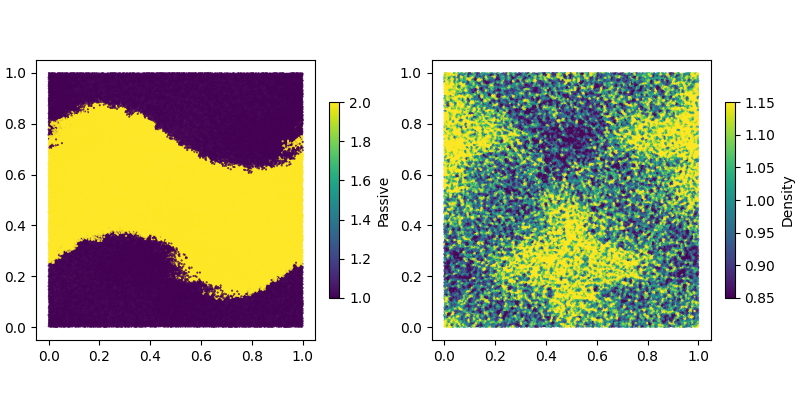

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(8,4), layout='constrained')

scatter1 = ax[0].scatter(X[:, 0], X[:, 1], c=passive, s=0.2, cmap='viridis')
ax[0].set_aspect(1.0)
fig.colorbar(scatter1, ax=ax[0], label='Passive', shrink=0.5)

scatter2 = ax[1].scatter(X[:, 0], X[:, 1], c=rho, s=0.2, cmap='viridis', vmin=0.85, vmax=1.15)
ax[1].set_aspect(1.0)
fig.colorbar(scatter2, ax=ax[1], label='Density', shrink=0.5)

# fig.savefig("../../Notes/fig/SPH_2d_KH_Balsara.pdf", dpi=300, bbox_inches='tight')

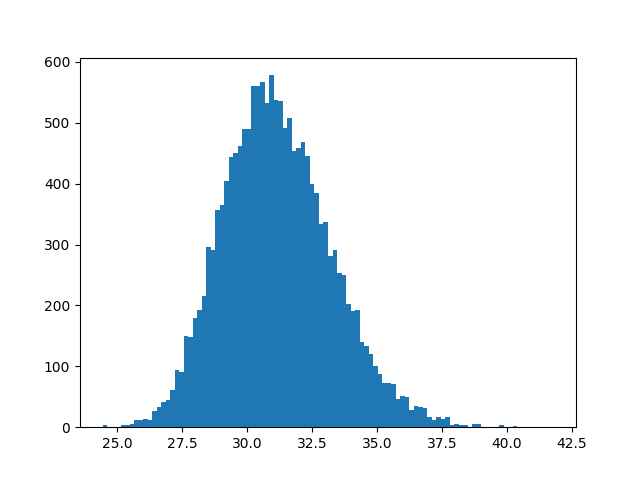

In [9]:
fig, ax = plt.subplots()
ax.hist( u, 100);